# Seasonal Time Series Prediction using an RNN

We predict the Retail Sales: Clothing and Clothing Accessory Stores data series from FRED.

https://fred.stlouisfed.org/series/MRTSSM448USN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Note that I make the DATE column the index of the dataframe
df = pd.read_csv("./data/MRTSSM448USN.csv", parse_dates = True, index_col="DATE") 

In [5]:
# import pandas_datareader.data as web
#df = web.DataReader("MRTSSM448USN", 'fred', start="19920101")

In [6]:
df.head(5)

,MRTSSM448USN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


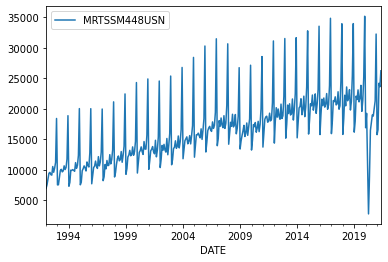

In [7]:
df.plot();

The drop at the end is due to the pandemic. Don't think any model will predict this. Let's drop it.

In [8]:
df = df[0:334]

Let's look at the data series we want to predict

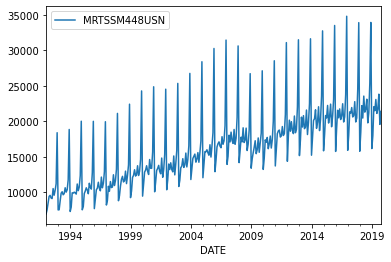

In [9]:
df.plot();

That's better !

## Data Preparation

We have monthly data. We use the last 18 months for the test size. 

In [10]:
n_train = df.shape[0] - 18

In [11]:
df_train = df[0:n_train]
df_test  = df[n_train:]

In [13]:
df_test.shape

(18, 1)

In [63]:
len(df_train), len(df_test)

(316, 18)

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_train)

MinMaxScaler()

In [65]:
df_train_scaled = scaler.transform(df_train)
df_test_scaled = scaler.transform(df_test)

## Batching using the Time Series Generator

The time series generator classs makes time series batching easier.

In [66]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [67]:
batch_length = 12 # Must be less than the size of the test set
batch_size = 1 # Number of batches in each training iteration

generator = TimeseriesGenerator(df_train_scaled, 
                                df_train_scaled, 
                                length=batch_length, 
                                batch_size=batch_size)

Let's examine the first batch

In [68]:
X, y = generator[0]

In [69]:
X

array([[[0.        ],
        [0.02101413],
        [0.05511726],
        [0.08832389],
        [0.09395396],
        [0.08047049],
        [0.07763752],
        [0.12820053],
        [0.09449186],
        [0.11891272],
        [0.15237037],
        [0.41085132]]])

In [70]:
y

array([[0.0202252]])

We can see the same first batch numbers and the next value below in the raw training data.

In [71]:
df_train_scaled[0:13]

array([[0.        ],
       [0.02101413],
       [0.05511726],
       [0.08832389],
       [0.09395396],
       [0.08047049],
       [0.07763752],
       [0.12820053],
       [0.09449186],
       [0.11891272],
       [0.15237037],
       [0.41085132],
       [0.0202252 ]])

## Building a Prediction Model using RNNs

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [73]:
n_features = 1 # it's a time series

In [74]:
model = Sequential()
model.add(LSTM(200, activation="relu", input_shape=(batch_length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [75]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               161600    
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


Set an early stopping mechanism so it does not take forever. This means that we stop after 2 epochs if there is no improvement.

In [76]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience = 2)

Generate another time series using the validation data.

In [77]:
validation_generator = TimeseriesGenerator(df_test_scaled, df_test_scaled, 
                                           length=batch_length, batch_size = batch_size)

In [78]:
model.fit(generator, epochs=20, 
          validation_data = validation_generator, 
          callbacks = [early_stop])

Epoch 1/20
304/304 [==============================] - 2s 3ms/step - loss: 0.0218 - val_loss: 0.0111
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0116 - val_loss: 0.0151
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0051 - val_loss: 0.0082
Epoch 4/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0032 - val_loss: 7.2146e-04
Epoch 5/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 5.5840e-04
Epoch 7/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0068
Epoch 8/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 7.7814e-04


In [79]:
losses = pd.DataFrame(model.history.history)

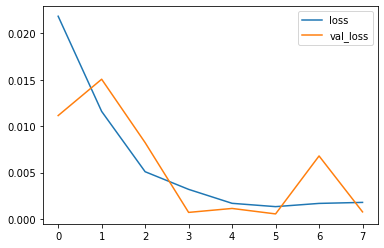

In [80]:
losses.plot();

Let's see how well the prediction looks on the test set.

In [81]:
test_predictions = []
first_eval_batch = df_train_scaled[-batch_length:]
current_batch = first_eval_batch.reshape((1, batch_length, n_features))

for i in range(len(df_test)):
    
    # predict one time step ahead
    current_pred = model.predict(current_batch)[0]
    
    # store the prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

We transformed the data so we invert the transform.

In [82]:
true_predictions = scaler.inverse_transform(test_predictions)

In [83]:
df_test['predictions'] = true_predictions

C:\Users\Dominic\AppData\Local\Temp/ipykernel_31148/244557866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions'] = true_predictions


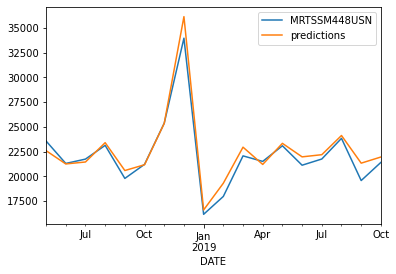

In [84]:
df_test.plot();

Looks ok !